This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
sys.path.insert(0, '../libraries/')
import gmm_clustering_lib as gmm_lib
import modeling_lib 
import utils_lib
import cluster_quantities_lib as cluster_lib
import optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

/home/runjing_liu/Documents/BNP/autograd/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

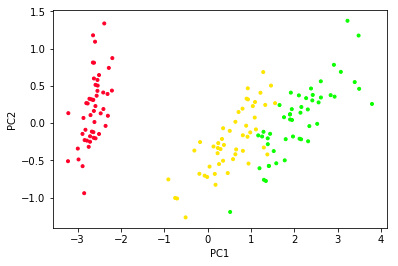

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 3.5
print(prior_params_dict)

{'alpha': 3.5, 'prior_centroid_mean': array([0.]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]])}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1460.205125758913

# Optimize the KL objective

### Initialize with k-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    optimization_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 453453)

print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
450.9718947107098


### Set up KL objective as a function of unconstrained VB parameters

In [10]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
get_vb_params_loss.cache_args(features, None, prior_params_dict,
                                gh_loc, gh_weights)

# Get loss as a function vb_free_params
get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
                                        patterns=vb_params_paragami,
                                        free=True)


### Run Newton 

In [11]:
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: -371.915284
         Iterations: 160
         Function evaluations: 331
         Gradient evaluations: 317

 running preconditioned newton; iter =  0
computing preconditioner 
running newton steps
         Current function value: -371.915284
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 0: x_diff = 2.1593815795779452e-12, f_diff = 4.547473508864641e-13, grad_l1 = 3.174373405431219e-05
done. 


In [14]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

### Check results

In [15]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


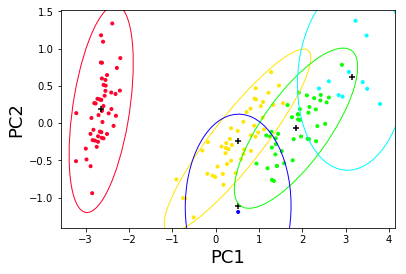

In [16]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Get the hyper parameter sensitivity object

In [17]:
get_prior_vb_loss = paragami.Functor(
    original_fun=gmm_lib.get_kl, argnums=[1, 2])

get_prior_vb_loss.cache_args(features, None, None, gh_loc, gh_weights)

In [18]:
vb_sens = \
    paragami.HyperparameterSensitivityLinearApproximation(
        objective_fun=           get_prior_vb_loss,
        opt_par_pattern=         vb_params_paragami,
        hyper_par_pattern=       prior_params_paragami,
        opt_par_folded_value=    vb_params_paragami.fold(vb_opt, free = True),
        hyper_par_folded_value=  prior_params_dict,
        opt_par_is_free=         True,
        hyper_par_is_free=       False,
        grad_tol=                1e-5)


### Set new prior

In [19]:
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha


In [20]:
print('initial alpha, ', prior_params_dict['alpha'])
print('perturbed alpha, ', prior_params_pert_dict['alpha'])

initial alpha,  3.5
perturbed alpha,  [5.]


### get linear response prediction

In [21]:
lr_vb_free_params = vb_sens.predict_opt_par_from_hyper_par(prior_params_pert_dict, fold_output = False)

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))

l_inf diff:  0.5023134408392484


### re-optimize

In [22]:
# set up new objective, with the prior changed
get_vb_params_loss.cache_args(features, None, prior_params_pert_dict, gh_loc, gh_weights)
get_pert_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
                                        patterns=vb_params_paragami,
                                        free=True)

In [23]:
# Run newton
vb_opt_pert = optimization_lib.optimize_full(get_pert_loss, deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: -357.909134
         Iterations: 101
         Function evaluations: 172
         Gradient evaluations: 160

 running preconditioned newton; iter =  0
computing preconditioner 
running newton steps
Optimization terminated successfully.
         Current function value: -357.909134
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 0: x_diff = 3.537039085569471e-05, f_diff = 9.663381206337363e-13, grad_l1 = 2.1939951039042665e-11
done. 


### Compare linear response with refitting

In [24]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

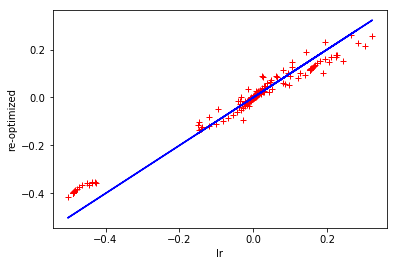

In [25]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

# Fit for a range of alpha 

In [26]:
alpha_list = np.arange(1, 15)

In [28]:
def refit_with_alpha(alpha, vb_opt):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # set up new objective, with the prior changed
    get_vb_params_loss.cache_args(features, None, prior_params_pert_dict, gh_loc, gh_weights)
    get_pert_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
                                            patterns=vb_params_paragami,
                                            free=True)
    
    # optimize
    vb_opt_pert = optimization_lib.optimize_full(get_pert_loss,deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

### Re-optimize for range of alphas

In [29]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [30]:
vb_pert_list = []
for alpha in alpha_list: 
    print('re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, vb_opt))

re-optimzing with alpha =  1
running bfgs ... 
         Current function value: -412.668542
         Iterations: 101
         Function evaluations: 182
         Gradient evaluations: 173

 running preconditioned newton; iter =  0
computing preconditioner 
running newton steps
Optimization terminated successfully.
         Current function value: -412.668542
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 0: x_diff = 2.0951476926889545e-05, f_diff = 1.4210854715202004e-12, grad_l1 = 1.318982304656087e-11
done. 
re-optimzing with alpha =  2
running bfgs ... 
         Current function value: -391.456873
         Iterations: 107
         Function evaluations: 135
         Gradient evaluations: 134

 running preconditioned newton; iter =  0
computing preconditioner 
running newton steps
Optimization terminated successfully.
         Current function value: -391.456873
         Iterations: 1
         Function evalu

### get linear response prediction for each alpha

In [34]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(prior_params_pert_dict, fold_output = False))
    

### examine results 

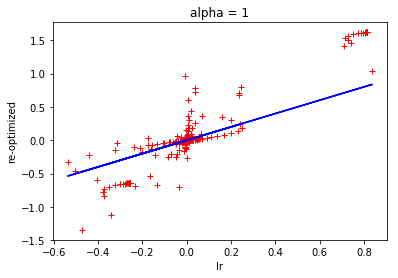

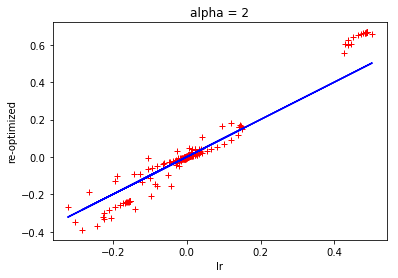

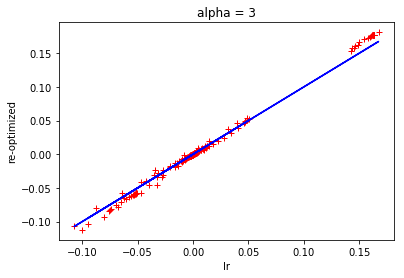

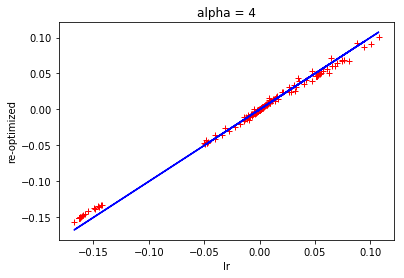

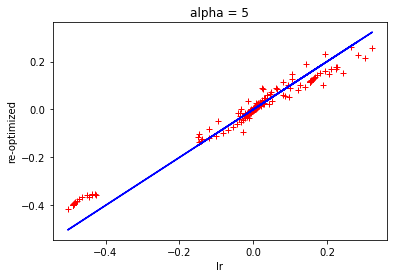

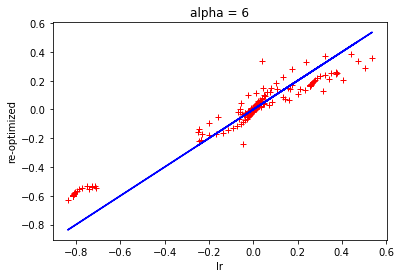

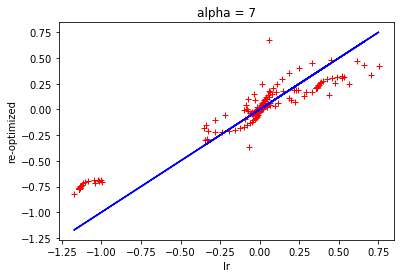

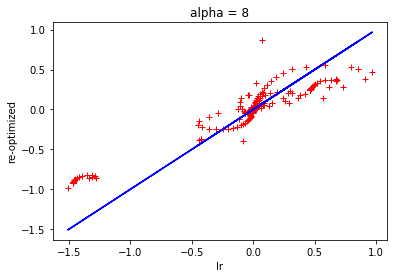

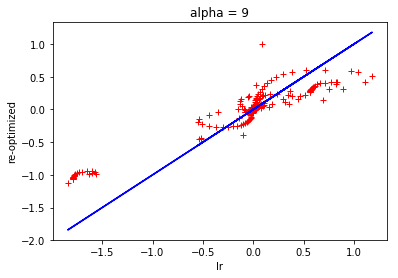

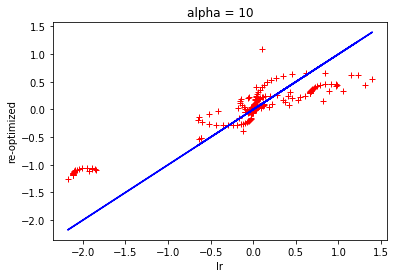

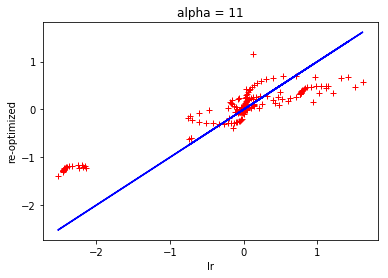

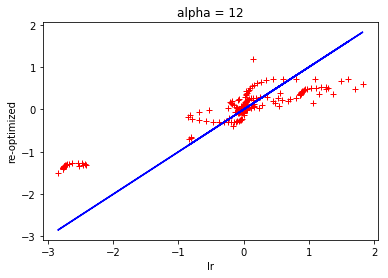

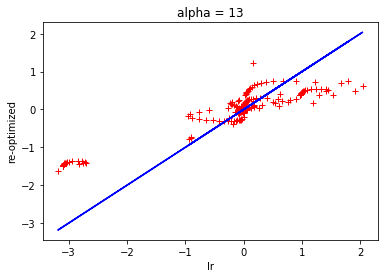

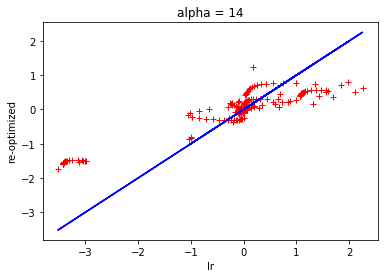

In [35]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    

# Check results on number of clusters

### results on number of in-sample clusters

In [37]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


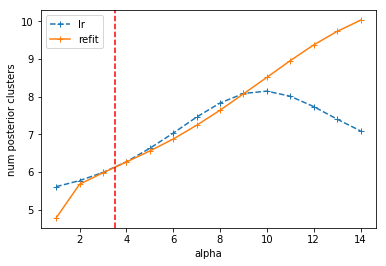

In [38]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


### Results on posterior predictive clusters

In [39]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    lr_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


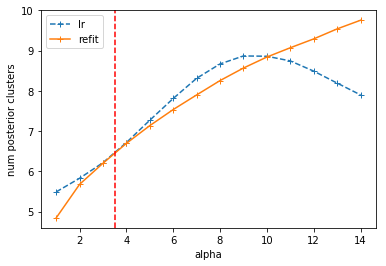

In [40]:
plt.plot(alpha_list, lr_e_num_pred_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')
